#Medical Code Prediction MIMIC-III
Robert Sato

Dr. Xin Wang

CSE 244B - Natural Language Processing

Winter 2022

**Plan**
- setup environment
    - setup github for this notebook
    - do not let the data be publicly accessible
- data analysis/preprocessing
    - understand the structure of the data
    - load into a readable/pliable format (pandas)
    - visualize some of the data
    - find the clinical notes
    - find the codes corresponding to the clinical notes (labels)
    - helper functions
        - create dataset (X, y)
            - shuffled randomized w validation split
- load a pretrained model
- read in the text as input
- multi-label classification
    
**Note**
MIMIC-IV note data is not available...
just use MIMIC-III for now

mimic-iii-dia-data was created from CAML-MIMIC github
- https://github.com/jamesmullenbach/caml-mimic
- [Explainable Prediction of Medical Codes from Clinical Text]
    - https://arxiv.org/abs/1802.05695


- data from CAML has much shorter text (they preprocessed) but their labels include words for some reason
- data from ICD prediction MIMIC has longer text but succint label column

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar 10 23:42:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

## loading from pickle 
- from [Predicting Multiple ICD-10 Codes from Brazilian-Portuguese Clinical Notes]
    - https://arxiv.org/pdf/2008.01515.pdf
    - https://github.com/3778/icd-prediction-mimic

In [32]:
data = pd.read_pickle("/content/gdrive/MyDrive/CSE_244B_W2022/project/mimic3_data.pkl")

In [33]:
data.head()

,HADM_ID,ICD9_CODE,SUBJECT_ID,TEXT
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Admission Date: [**2117-9-11**] ...
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",54610,Admission Date: [**2150-4-17**] ...
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",9895,Admission Date: [**2108-4-6**] Discharg...
3,100007,"[56081, 5570, 9973, 486, 4019]",23018,Admission Date: [**2145-3-31**] ...
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148...",533,Admission Date: [**2162-5-16**] ...


In [ ]:
data.describe()

,HADM_ID,SUBJECT_ID
count,52722.000000,52722.000000
mean,149987.468230,35177.283449
std,28910.706251,28570.362362
min,100001.000000,3.000000
25%,124922.250000,12566.000000
50%,150098.500000,25251.000000
75%,175033.250000,57170.500000
max,199999.000000,99999.000000


In [ ]:
print('average diagnosis length: ', data.TEXT.str.split().str.len().mean())
print('stdev diagnosis length: ', data.TEXT.str.split().str.len().std())

average diagnosis length:  1551.5281666097644
stdev diagnosis length:  781.001080162633


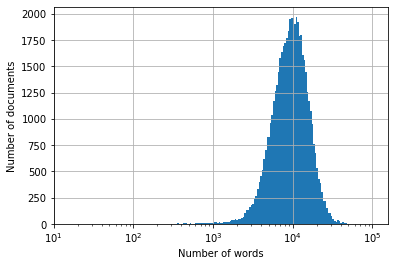

In [ ]:
bin_list = np.logspace(1,5,num=200)

ax = (data
       .TEXT
       .apply(len)
       .plot
       .hist(bins=bin_list,logx=True)
);

ax.set_xlabel('Number of words')
ax.set_ylabel('Number of documents')
ax.set_xlim(left=10e0)
ax.grid()

fig = ax.get_figure()

In [ ]:
MIMIC_AVG = data.ICD9_CODE.explode().shape[0]/data.shape[0]

print(f'Average ICD codes per sample: {MIMIC_AVG:.2f}')

Average ICD codes per sample: 11.74


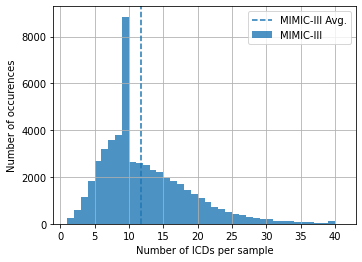

In [ ]:
icd_bins= np.linspace(1,41,41,dtype='int32')

ax = (data
      .ICD9_CODE
      .apply(lambda x: len(x))
      .plot
      .hist(bins=icd_bins, alpha=0.8)
     )

ax.set_xlabel('Number of ICDs per sample')
ax.set_ylabel('Number of occurences')
ax.axvline(MIMIC_AVG, linestyle='--', color='C0')
ax.legend(['MIMIC-III Avg.','MIMIC-III'])
ax.grid()

fig = ax.get_figure()
fig.subplots_adjust(left=0.15, right=0.85)

## Load the Data
- MIMIC-IV note data not available
- TF, use MIMIC-III

Data Needed for Diagnosis Classification
- NOTEEVENTS.csv - actual notes from doctor's diagnoses
- ADMISSIONS.csv - admission info (in time/out time)
- DIAGNOSES_ICD.csv - ICD to predict

In [ ]:
#MIMIC_IV_data_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/mimic-iv-1.0/"
MIMIC_III_data_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/mimic-iii_dia_data/"

In [ ]:
!ls $MIMIC_III_data_path

DIA_PLUS_adm_test.csv  DIA_PLUS_adm_train.csv  DIA_PLUS_adm_val.csv


In [ ]:
train = pd.read_csv(MIMIC_III_data_path + 'DIA_PLUS_adm_train.csv')
test = pd.read_csv(MIMIC_III_data_path + 'DIA_PLUS_adm_test.csv')
val = pd.read_csv(MIMIC_III_data_path + 'DIA_PLUS_adm_val.csv')

In [ ]:
train.head()

,id,text,labels
0,159643,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This 60 ...,",276,2765,2767,412,414,4140,424,4241,427,4273,..."
1,147171,CHIEF COMPLAINT: Substernal Chest Pain\n\nPRES...,"410,4101,414,4140,427,4271,4273,428,4280,4282,..."
2,199961,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,",250,2506,285,2859,403,4039,707,7070,720,7200,..."
3,136812,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This is ...,",244,2449,276,2765,280,2800,426,4261,427,4278,..."
4,175700,CHIEF COMPLAINT: s/p rollover MVC with prolong...,"285,2851,327,3272,481,518,5180,799,7990,807,80..."


In [ ]:
print('average diagnosis length: ', train.text.str.split().str.len().mean())
print('stdev diagnosis length: ', train.text.str.split().str.len().std())

average diagnosis length:  395.8866270518327
stdev diagnosis length:  235.62215600801855


In [ ]:
# get the labels for one training example
labels = train['labels'].iloc[1]
print(labels)

410,4101,414,4140,427,4271,4273,428,4280,4282,458,4582,997,9971,acute,anterior,artery,atherosclerosis,atrial,cardiac,care,classified,complications,congestive,coronary,elsewhere,episode,failure,fibrillation,heart,hypotension,iatrogenic,infarction,initial,myocardial,native,paroxysmal,systolic,tachycardia,unspecified,ventricular,wall


In [ ]:
train_1_labels = list(train[train['id']==100001]['labels'])
data_1_labels = list(data[data['HADM_ID']==100001]['ICD9_CODE'])
print(train_1_labels, "\n", data_1_labels)

['250,2501,2504,2505,2506,2508,337,3371,362,3620,403,4039,458,4580,536,5363,578,5780,584,5849,585,5853,707,7078,V135,V1351,V586,V5867,acute,autonomic,background,chronic,classified,current,diabetes,diabetic,disease,disorders,elsewhere,failure,fracture,gastroparesis,hematemesis,history,hypertensive,hypotension,iii,insulin,iv,juvenile,ketoacidosis,kidney,longterm,manifestations,moderate,neurological,neuropathy,ophthalmic,orthostatic,pathologic,peripheral,personal,renal,retinopathy,sites,specified,stage,type,ulcer,uncontrolled,unspecified,use'] 
 [array(['25013', '3371', '5849', '5780', 'V5867', '25063', '5363', '4580',
       '25043', '40390', '5853', '25053', '36201', '25083', '7078',
       'V1351'], dtype=object)]


In [ ]:
train[train['id']==100001].head()

,id,text,labels
25218,100001,"CHIEF COMPLAINT: nausea, vomiting\n\nPRESENT I...","250,2501,2504,2505,2506,2508,337,3371,362,3620..."


In [ ]:
data[data['HADM_ID']==100001].head()

,HADM_ID,ICD9_CODE,SUBJECT_ID,TEXT
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Admission Date: [**2117-9-11**] ...


## Create vector representations for the texts

### Convert the ICD code lists to a one hot vector

In [ ]:
# find all unique codes in the ICD9_CODE column
all_codes = set()
for i, row in data.iterrows():
    codes = row['ICD9_CODE']
    for code in codes:
        all_codes.add(code)
print(all_codes)
code_count = len(all_codes)
print(code_count, "unique codes found")

{'76498', '3688', 'E9850', '87350', '5565', '30747', '82310', 'V5863', '87261', '75263', '3552', '4257', '61610', '29680', '20380', '47830', '42989', '94323', 'E8131', 'V153', '5851', '29653', '30302', '30749', '80624', '34680', 'V111', '40490', '33384', '73004', 'E8314', '5269', '72782', '2358', '2693', '8083', '4171', '5581', '8246', 'E9399', '74686', 'V553', '73741', '88001', '9108', '2394', '2948', '22804', '0543', '80702', 'V468', '99809', '27651', '3699', '75450', '2104', 'V8537', '71233', '52406', '8745', '71901', '8025', '0971', '3003', '99661', '86354', '80325', '66932', 'E8669', 'E9588', '46431', 'V289', '1509', 'E9345', '7019', '42099', '40411', '94321', '43301', '29690', '57471', '64204', '9596', '29410', 'E0011', '1463', '99687', '43490', '05311', '92810', '7089', 'E8600', '20963', '8250', '20260', 'V660', '28246', '60782', 'V444', '60010', '30521', '5733', 'V1062', '37652', '9531', 'E9343', 'V4361', 'E9357', '5233', '1922', '57512', '78650', '85162', '9708', '8711', '6078

In [ ]:
# create translation dictionaries
index_to_code = {i: code for i, code in enumerate(all_codes)}
print(index_to_code)
code_to_index = {code: i for i, code in enumerate(all_codes)}
print(code_to_index)

{0: '76498', 1: '3688', 2: 'E9850', 3: '87350', 4: '5565', 5: '30747', 6: '82310', 7: 'V5863', 8: '87261', 9: '75263', 10: '3552', 11: '4257', 12: '61610', 13: '29680', 14: '20380', 15: '47830', 16: '42989', 17: '94323', 18: 'E8131', 19: 'V153', 20: '5851', 21: '29653', 22: '30302', 23: '30749', 24: '80624', 25: '34680', 26: 'V111', 27: '40490', 28: '33384', 29: '73004', 30: 'E8314', 31: '5269', 32: '72782', 33: '2358', 34: '2693', 35: '8083', 36: '4171', 37: '5581', 38: '8246', 39: 'E9399', 40: '74686', 41: 'V553', 42: '73741', 43: '88001', 44: '9108', 45: '2394', 46: '2948', 47: '22804', 48: '0543', 49: '80702', 50: 'V468', 51: '99809', 52: '27651', 53: '3699', 54: '75450', 55: '2104', 56: 'V8537', 57: '71233', 58: '52406', 59: '8745', 60: '71901', 61: '8025', 62: '0971', 63: '3003', 64: '99661', 65: '86354', 66: '80325', 67: '66932', 68: 'E8669', 69: 'E9588', 70: '46431', 71: 'V289', 72: '1509', 73: 'E9345', 74: '7019', 75: '42099', 76: '40411', 77: '94321', 78: '43301', 79: '29690'

In [ ]:
# helper function to create one hot encoding from a list of indices
def create_one_hot(codes, code_to_index=code_to_index, code_count=code_count):
    ohe = np.zeros(shape=(code_count,), dtype="ubyte") # not sure if i should spec dtype
    for code in codes:
        ohe[code_to_index[code]] = 1
    return ohe

In [ ]:
# test ohe create function
d = data['ICD9_CODE'].iloc[0]
ohe = create_one_hot(d)
print("OHE sums to:", np.sum(ohe), "and data has length:", len(d))
print("First code:", d[0], 
      "corresponds to index:", code_to_index[d[0]],
      "\nOHE at that index:", ohe[code_to_index[d[0]]])
print(type(ohe[0]))

OHE sums to: 16 and data has length: 16
First code: 25013 corresponds to index: 3788 
OHE at that index: 1
<class 'numpy.uint8'>


In [ ]:
# extract the texts as X and one hot encoding of labels to y
X = [] # diagnosis notes
y = [] # icd codes represented as multi-label OHE
for i, row in data.iterrows():
    codes = row['ICD9_CODE']
    X.append(row['TEXT'])
    y.append(create_one_hot(codes))
print("Length of texts (X):", len(X))
y = np.asarray(y)
print("y shape:", y.shape)

Length of texts (X): 52722
y shape: (52722, 6918)


In [ ]:
type(data['TEXT'].iloc[0]) == type(X[0])

True

### Create tokenized inputs
- from above, stored as X (list of str from "TEXT" column of data)

reference: https://www.youtube.com/watch?v=pjtnkCGElcE

#### Preprocess
ref: ICD-Prediction-MIMIC

In [ ]:
def preprocess(text_series):
    return (text_series
            .str.replace('\[\*\*[^\]]*\*\*\]','')
            .str.replace('<[^>]*>', '')
            .str.replace('[\W]+', ' ')
            .str.lower()
            .str.replace(' \d+', ' '))
            #.str.split())

In [ ]:
print('average diagnosis length: ', data.TEXT.str.split().str.len().mean())
print('stdev diagnosis length: ', data.TEXT.str.split().str.len().std())

average diagnosis length:  1551.5281666097644
stdev diagnosis length:  781.001080162633


In [ ]:
data['TEXT'] = data['TEXT'].pipe(preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
#print('average diagnosis length: ', data.TEXT.str.len().mean())
#print('stdev diagnosis length: ', data.TEXT.str.len().std())
print('average diagnosis length: ', data.TEXT.str.split().str.len().mean())
print('stdev diagnosis length: ', data.TEXT.str.split().str.len().std())

average diagnosis length:  1327.499962065172
stdev diagnosis length:  654.2358886422546


#### Embed

In [ ]:
!pip install transformers
import transformers

     |████████████████████████████████| 3.8 MB 50 kB/s 
     |████████████████████████████████| 6.5 MB 66.7 MB/s 
     |████████████████████████████████| 895 kB 80.2 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# tokenize
seq_len = 128 # this must be in line with the transformer model's expected seq len (BERT 512, ClinBERT 128)
num_samples = len(X)

Xids = np.zeros((num_samples, seq_len), dtype='int32')
Xmask = np.zeros((num_samples, seq_len), dtype='int32')

Xids.shape

(52722, 128)

In [ ]:
X[0]

'admission date discharge date date of birth sex f service medicine allergies levaquin attending chief complaint nausea vomiting major surgical or invasive procedure none history of present illness f w poorly controlled type  diabetes mellitus w neuropathy nephropathy htn gastroparesis ckd and retinopathy recently hospitalized for orthostatic hypotension autonomic neuropathy dka hospitalizations in and now returning w d history of worsening nausea vomiting with coffee ground emesis chills and dyspnea on exertion last week she had a fall and hit her right face she also had  day of diarrhea which resolved early last week found to be in dka with ag  and bicarb  in the ed inital vitals were           ra k   hco3  anion gap  cr   baseline     she is on her rd l ns insulin srip at  units hr on home at  levemir in am and  at with difficult to control sugars bps have been high given  mtroprolol tartrate in ed she was started on an insulin drip at  units hr and l ns boluses also aspirin mg po a

In [ ]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizer 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


In [ ]:
for i, phrase in enumerate(X):
    print(i)
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # add to zero arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

Streaming output truncated to the last 5000 lines.
47722
47723
47724
47725
47726
47727
47728
47729
47730
47731
47732
47733
47734
47735
47736
47737
47738
47739
47740
47741
47742
47743
47744
47745
47746
47747
47748
47749
47750
47751
47752
47753
47754
47755
47756
47757
47758
47759
47760
47761
47762
47763
47764
47765
47766
47767
47768
47769
47770
47771
47772
47773
47774
47775
47776
47777
47778
47779
47780
47781
47782
47783
47784
47785
47786
47787
47788
47789
47790
47791
47792
47793
47794
47795
47796
47797
47798
47799
47800
47801
47802
47803
47804
47805
47806
47807
47808
47809
47810
47811
47812
47813
47814
47815
47816
47817
47818
47819
47820
47821
47822
47823
47824
47825
47826
47827
47828
47829
47830
47831
47832
47833
47834
47835
47836
47837
47838
47839
47840
47841
47842
47843
47844
47845
47846
47847
47848
47849
47850
47851
47852
47853
47854
47855
47856
47857
47858
47859
47860
47861
47862
47863
47864
47865
47866
47867
47868
47869
47870
47871
47872
47873
47874
47875
47876
47877
47878
47879
4

In [ ]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(128,), dtype=tf.int32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None), TensorSpec(shape=(6918,), dtype=tf.uint8, name=None))>

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [ ]:
dataset = dataset.map(map_func)

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None)}, TensorSpec(shape=(6918,), dtype=tf.uint8, name=None))>

In [ ]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

In [ ]:
# save the dataset
ds_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/clinicalBERT_128"
tf.data.experimental.save(dataset, ds_path)

## Load previously created Dataset

In [4]:
# load the dataset
ds_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/clinicalBERT_128"
dataset = tf.data.experimental.load(ds_path)
dataset.take(1)

<TakeDataset element_spec=({'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None), 'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

In [5]:
split = 0.9

seq_len = 128
num_samples = 52722
batch_size = 16

size = int((num_samples / batch_size) * split)

In [6]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

In [7]:
train_ds.take(1)

<TakeDataset element_spec=({'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None), 'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

In [8]:
val_ds.take(1)

<TakeDataset element_spec=({'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None), 'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

## Create model

In [ ]:
len(X)

52722

In [9]:
#num_classes = y.shape[1]
num_classes = 6918
num_classes

6918

#### BERT Model

In [10]:
!pip install transformers
from transformers import TFAutoModel, TFBertForSequenceClassification
#bert = TFAutoModel.from_pretrained("bert-base-uncased")
#bert = TFAutoModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
#bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 64.4 MB/s 
     |████████████████████████████████| 596 kB 76.8 MB/s 
     |████████████████████████████████| 6.5 MB 56.9 MB/s 
     |████████████████████████████████| 67 kB 7.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

NameError: ignored

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
distilBERT.summary()

Model: "tf_distil_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# DistilBERT outputs a tuple where the first element at index 0
# represents the hidden-state at the output of the model's last layer.
# It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
last_hidden_state = distilBERT.bert([input_ids, mask])[0]

# We only care about DistilBERT's output for the [CLS] token, 
# which is located at index 0 of every encoded sequence.  
# Splicing out the [CLS] tokens gives us 2D data.
cls_token = last_hidden_state[:, 0, :]

##                                                 ##
## Define additional dropout and dense layers here ##
##                                                 ##
output = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(cls_token)


# Define the model
model = tf.keras.Model([input_ids, mask], output)
model.summary()

AttributeError: ignored

In [ ]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

#x = tf.keras.layers.Dense(1024, activation='relu')(embeddings) # training is 2 days rn
#y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(embeddings)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, mask],  outputs=y)

# if you dont want to train the 100M bert params
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 1024)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 1024)]       0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 1024                                           

In [12]:
# clinicalBERT
clin_bert = TFAutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", from_pt=True)

input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = clin_bert.bert(input_ids, attention_mask=mask)[1]

x = tf.keras.layers.Dense(768, activation='relu')(embeddings) # training is 2 days rn
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask],  outputs=y, name='clinicalBERT')

# if you dont want to train the 100M bert params
model.layers[2].trainable = False
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "clinicalBERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                    

### Load a model

In [22]:
model_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/models"
model_path += 'clinicalBERT128_5ep'
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "clinicalBERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (Custom>TFBertMainLayer)  {'last_hidden_state  108310272   ['input_ids[0][0]',              
                                ': (None, 128, 768)               'attention_mask[0][0]']         
                                , 'pooler_output':                                                
                                (None, 768)}                                           

### Baseline Model - read string inputs

In [ ]:
from keras.preprocessing import sequence
from keras.layers import TextVectorization

In [ ]:
# load the dataset but only keep the top n words, zero the rest
(X_train, y_train), (X_test, y_test) = (X[:int(len(X)*0.8)], y[:int(len(X)*0.8)]), (X[int(len(X)*0.8):], y[int(len(X)*0.8):])
y_train.shape

(42177, 6918)

In [ ]:
vectorize_layer = TextVectorization(max_tokens=10000,
                                    standardize='lower_and_strip_punctuation',
                                    output_mode='int',
                                    output_sequence_length=200)

In [ ]:
vectorize_layer.adapt(X)

In [ ]:
input = tf.keras.layers.Input(shape=(seq_len,), name='input', dtype='int32') 

x = tf.keras.layers.Conv1D(128, 3, activation='relu')(input_ids)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

ValueError: ignored

In [ ]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input_ids)
x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

ValueError: ignored

In [ ]:
# screw everything just do classification on the X input statements like the fake news detection hw
# create the model
# https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
embedding_vecor_length = 256
top_words = 5000
max_diagnosis_length = 1024

input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
x = tf.keras.layers.Embedding(top_words, embedding_vecor_length, input_length=max_diagnosis_length)(input_ids)
x = tf.keras.layers.LSTM(64)(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, mask],  outputs=y)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 1024)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1024, 256)    1280000     ['input_ids[0][0]']              
                                                                                                  
 lstm_3 (LSTM)                  (None, 64)           82176       ['embedding_3[0][0]']            
                                                                                                  
 attention_mask (InputLayer)    [(None, 1024)]       0           []                               
                                                                                            

### Train

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [14]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [81]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
2965/2965 [==============================] - 292s 99ms/step - loss: 0.0082 - accuracy: 0.0111 - val_loss: 0.0080 - val_accuracy: 0.0044
Epoch 2/10
2965/2965 [==============================] - 292s 98ms/step - loss: 0.0082 - accuracy: 0.0109 - val_loss: 0.0080 - val_accuracy: 0.0044
Epoch 3/10
2965/2965 [==============================] - 292s 99ms/step - loss: 0.0082 - accuracy: 0.0109 - val_loss: 0.0080 - val_accuracy: 0.0042
Epoch 4/10
2965/2965 [==============================] - 292s 99ms/step - loss: 0.0082 - accuracy: 0.0105 - val_loss: 0.0080 - val_accuracy: 0.0047
Epoch 5/10
2965/2965 [==============================] - 291s 98ms/step - loss: 0.0081 - accuracy: 0.0105 - val_loss: 0.0079 - val_accuracy: 0.0047
Epoch 6/10
2965/2965 [==============================] - 290s 98ms/step - loss: 0.0081 - accuracy: 0.0112 - val_loss: 0.0079 - val_accuracy: 0.0047
Epoch 7/10
2965/2965 [==============================] - 290s 98ms/step - loss: 0.0081 - accuracy: 0.0098 - val_loss: 0

In [82]:
model_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/models"
model_path += 'clinicalBERT128_dropout_10+20ep'
#print("Enter a model name:")
#model_path += input()
model.save(model_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/CSE_244B_W2022/project/modelsclinicalBERT128_dropout_10+20ep/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/CSE_244B_W2022/project/modelsclinicalBERT128_dropout_10+20ep/assets


### Analysis

In [83]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

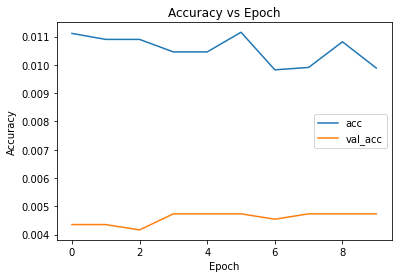

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['acc', 'val_acc'])
plt.show()

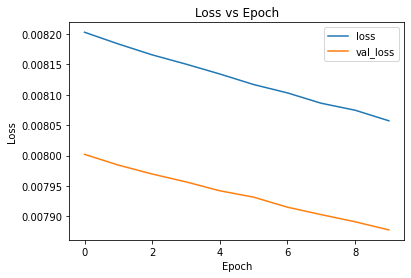

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['loss', 'val_loss'])
plt.show()

#### Compute scores

In [86]:
# get predictions
y_pred = model.predict(val_ds)
y_pred.shape

(5280, 6918)

In [87]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.asarray(y_true)
y_true.shape

(5280, 6918)

In [89]:
# AUC
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, f1_score, average_precision_score, recall_score
from sklearn.metrics import precision_score

In [90]:
micro_auc = roc_auc_score(y_true, y_pred, average='micro', multi_class='ovr')
print(f"Micro-AUC: {micro_auc}")

Micro-AUC: 0.9564509896693167
Micro-AUC: 0.509888359368912
Micro-AUC: 0.509888359368912


In [91]:
average_precision = average_precision_score(y_true, y_pred, average='micro')
print(f"Micro-average precision: {average_precision}")

Micro-average precision: 0.1539024870281619
Micro-average precision: 0.014339097111537028
Micro-average precision: 0.014339097111537028
